# Spot ROI and Mask Analysis (Final)

This notebook analyzes previously generated **ImageJ ROIs** against **Cellpose Masks**.

**Workflow**:
1.  **Matches Files**: Finds triplets of files for each image:
    *   Mask: `..._cells_mask.tif` (or `..._cell_mask.tif`)
    *   Channel 1 ROIs: `..._C1_ROIs.zip`
    *   Channel 2 ROIs: `..._C2_ROIs.zip`
2.  **Process Masks**:
    *   Count cells.
    *   **Standard Erosion**: Erode mask by **4 pixels** (General Inside).
    *   **Deep Erosion**: Erode mask by **20 pixels** (Deep Internal).
3.  **Analyze ROIs**:
    *   Extract coordinates from `.zip` files.
    *   **Channel 1**: Count total spots.
    *   **Channel 2**: Count total, check if **Inside (4px)**, **Deep Inside (20px)**, or **Outside**.
4.  **Calculations**: Computes **Spots per Cell**.
5.  **Output**: Saves `ROI_Analysis_Results.csv`.
6.  **Visualization**: Boxplots comparing groups (DI_Gastro, Saline_Gastro, WT_Gastro).

In [1]:
# Install necessary library for reading ImageJ ROIs
%pip install roifile pandas tifffile scikit-image matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import tifffile
import roifile
from skimage import morphology
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parameters ---

# Directory containing your masks and ROI zips
data_dir = r"S:\micro\ts2625\eh2888\lem\20260128_EVE_LargeImage\tiff\quantification\cellmask"

erosion_pixels = 4       # Standard Erosion
deep_erosion_pixels = 20 # Deep Internal Definition

# --- Helper Functions ---

def get_roi_coordinates(roi_path):
    """
    Reads an ImageJ ROI zip file and returns a list of (y, x) coordinates.
    Handles Point ROIs and MultiPoint ROIs.
    """
    coords = []
    try:
        rois = roifile.ImagejRoi.fromfile(roi_path)
        
        # roifile.fromfile can return a single object or a list
        if not isinstance(rois, list):
            rois = [rois]
            
        for roi in rois:
            # roifile.coordinates usually returns [y, x]
            pts = roi.coordinates()
            
            # If it's a single point, pts might be 1D or (1, 2)
            if pts.ndim == 1:
                pts = pts.reshape(1, -1)
            
            # Append to master list
            for p in pts:
                coords.append(p)  
                
    except Exception as e:
        print(f"Error reading ROI file {os.path.basename(roi_path)}: {e}")
        
    return np.array(coords)

def erode_mask(mask, pixels=4):
    binary_mask = mask > 0
    selem = morphology.disk(pixels)
    eroded = morphology.binary_erosion(binary_mask, selem)
    return eroded

def find_file_triplets(directory):
    """
    Matches Mask files with corresponding C1 and C2 ROI files.
    Robust strategy: Matches based on filename patterns and verifies file existence.
    """
    triplets = []
    
    # Look for both common mask endings
    possible_masks = glob.glob(os.path.join(directory, "*_cells_mask.tif")) + \
                     glob.glob(os.path.join(directory, "*_cell_mask.tif"))
    
    # De-duplicate if needed
    possible_masks = sorted(list(set(possible_masks)))
    
    for mask_path in possible_masks:
        filename = os.path.basename(mask_path)
        
        # Generate candidate base IDs to check
        candidates = []
        
        if "_ch1_cells_mask.tif" in filename:
            candidates.append(filename.replace("_ch1_cells_mask.tif", ""))
        
        if "_cells_mask.tif" in filename:
            candidates.append(filename.replace("_cells_mask.tif", ""))
            
        if "_cell_mask.tif" in filename:
            candidates.append(filename.replace("_cell_mask.tif", ""))
            
        # Also try strict splitting by underscore as fallback
        candidates.append(filename.rsplit('_', 2)[0])
        
        # Remove duplicates while preserving order
        unique_candidates = []
        [unique_candidates.append(x) for x in candidates if x not in unique_candidates]
        
        found_match = False
        
        for base_id in unique_candidates:
            c1_path = os.path.join(directory, base_id + "_C1_ROIs.zip")
            c2_path = os.path.join(directory, base_id + "_C2_ROIs.zip")
            
            if os.path.exists(c1_path) and os.path.exists(c2_path):
                triplets.append({
                    'id': base_id,
                    'mask': mask_path,
                    'c1_roi': c1_path,
                    'c2_roi': c2_path
                })
                found_match = True
                break # Stop checking candidates for this mask
        
        if not found_match:
            print(f"Warning: Could not find ROI pairs for mask: {filename}")
            
    return triplets

def inspect_first_roi(directory):
    """
    Finds the first ROI zip file and prints its internal structure.
    Useful for verifying if it's Single points, MultiPoints, etc.
    """
    zips = glob.glob(os.path.join(directory, "*_ROIs.zip"))
    if not zips:
        print("No ROI zip files found for inspection.")
        return
        
    sample_file = zips[0]
    print(f"--- Inspecting Sample ROI File: {os.path.basename(sample_file)} ---")
    
    try:
        rois = roifile.ImagejRoi.fromfile(sample_file)
        if not isinstance(rois, list):
            rois = [rois]
            
        print(f"Number of ROI entries in zip: {len(rois)}")
        for i, roi in enumerate(rois[:5]):
            print(f"  ROI {i+1}: Name='{roi.name}', Type={roi.roitype}, Coords Shape={roi.coordinates().shape}")
        if len(rois) > 5:
            print(f"  ... and {len(rois)-5} more.")
            
    except Exception as e:
        print(f"Error reading sample: {e}")
    print("--------------------------------------------------\n")

# --- Main Loop ---

inspect_first_roi(data_dir)

triplets = find_file_triplets(data_dir)
print(f"Found {len(triplets)} complete sets to analyze.")

results = []

for t in triplets:
    print(f"Processing {t['id']}...")
    
    # 1. Load Mask
    mask = tifffile.imread(t['mask'])
    
    # Count Cells
    cell_ids = np.unique(mask)
    cell_count = len(cell_ids[cell_ids != 0])
    
    # Erode Mask (Standard 4px)
    eroded_std = erode_mask(mask, pixels=erosion_pixels)
    
    # Erode Mask (Deep 20px)
    eroded_deep = erode_mask(mask, pixels=deep_erosion_pixels)
    
    # 2. Process Channel 1 ROIs
    c1_coords = get_roi_coordinates(t['c1_roi'])
    c1_total = len(c1_coords)
    
    # 3. Process Channel 2 ROIs
    c2_coords = get_roi_coordinates(t['c2_roi'])
    c2_total = len(c2_coords)
    
    c2_inside = 0
    c2_deep_inside = 0
    c2_outside = 0
    
    h, w = mask.shape
    
    for coord in c2_coords:
        y, x = int(round(coord[0])), int(round(coord[1]))
        
        # Boundary check
        if 0 <= x < w and 0 <= y < h:
            # Check Standard Inside (4px)
            if eroded_std[y, x]:
                c2_inside += 1
            else:
                c2_outside += 1
                
            # Check Deep Inside (20px)
            if eroded_deep[y, x]:
                c2_deep_inside += 1
        else:
            c2_outside += 1
            
    results.append({
        'Filename': t['id'],
        'Cell_Count': cell_count,
        'Ch1_Spots': c1_total,
        'Ch2_Spots_Total': c2_total,
        'Ch2_Inside': c2_inside,
        'Ch2_Deep_Inside': c2_deep_inside,
        'Ch2_Outside': c2_outside
    })

# Create DataFrame
df = pd.DataFrame(results)

# --- Group Parsing ---
df['Group'] = df['Filename'].apply(lambda x: "_".join(x.split("_")[:2]))

# --- Calculations (Spots per Cell) ---
df['Ch1_per_Cell'] = df.apply(lambda row: row['Ch1_Spots'] / row['Cell_Count'] if row['Cell_Count'] > 0 else 0, axis=1)
df['Ch2_Total_per_Cell'] = df.apply(lambda row: row['Ch2_Spots_Total'] / row['Cell_Count'] if row['Cell_Count'] > 0 else 0, axis=1)
df['Ch2_Inside_per_Cell'] = df.apply(lambda row: row['Ch2_Inside'] / row['Cell_Count'] if row['Cell_Count'] > 0 else 0, axis=1)
df['Ch2_Deep_Inside_per_Cell'] = df.apply(lambda row: row['Ch2_Deep_Inside'] / row['Cell_Count'] if row['Cell_Count'] > 0 else 0, axis=1)

# Save Results
csv_path = os.path.join(data_dir, 'ROI_Analysis_Results.csv')
df.to_csv(csv_path, index=False)

print(f"Done! Results saved to {csv_path}")
display(df.head())

--- Inspecting Sample ROI File: WT_Gastro_0001_00001-10239-08634_C2_ROIs.zip ---
Number of ROI entries in zip: 1
  ROI 1: Name='WT_Gastro_0001_00001-10239-08634_C2', Type=10, Coords Shape=(429, 2)
--------------------------------------------------

Found 22 complete sets to analyze.
Processing DI_Gastro_0002_00001-03584-05314...
Processing DI_Gastro_0002_00001-05940-03286...
Processing DI_Gastro_0004_00001-05012-07199...
Processing DI_Gastro_0004_00001-05015-05372...
Processing DI_Gastro_0004_00001-06675-05268...
Processing Saline_Gastro_00001-04476-07542...
Processing Saline_Gastro_00001-09822-04812...
Processing Saline_Gastro_00002-11874-04140...
Processing Saline_Gastro_0001_00001-05528-05766...
Processing Saline_Gastro_0001_00001-08477-04522...
Processing Saline_Gastro_0002_00001-04008-12188...
Processing Saline_Gastro_0002_00001-12912-04334...
Processing Saline_Gastro_0003_00001-03795-13410...
Processing Saline_Gastro_0003_00001-11583-02984...
Processing Saline_Gastro_0003_00001-1

,Filename,Cell_Count,Ch1_Spots,Ch2_Spots_Total,Ch2_Inside,Ch2_Deep_Inside,Ch2_Outside,Group,Ch1_per_Cell,Ch2_Total_per_Cell,Ch2_Inside_per_Cell,Ch2_Deep_Inside_per_Cell
0,DI_Gastro_0002_00001-03584-05314,366,140,792,496,204,296,DI_Gastro,0.382514,2.163934,1.355191,0.557377
1,DI_Gastro_0002_00001-05940-03286,334,168,951,520,281,431,DI_Gastro,0.502994,2.847305,1.556886,0.841317
2,DI_Gastro_0004_00001-05012-07199,150,125,335,181,74,154,DI_Gastro,0.833333,2.233333,1.206667,0.493333
3,DI_Gastro_0004_00001-05015-05372,188,134,434,229,101,205,DI_Gastro,0.712766,2.308511,1.218085,0.537234
4,DI_Gastro_0004_00001-06675-05268,297,183,771,484,204,287,DI_Gastro,0.616162,2.595960,1.629630,0.686869


## Visualization
Including **Deep Internal (20px)** data.

C:\Users\zyu\AppData\Local\Temp\ipykernel_11952\1336336825.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Ch1_per_Cell', data=df, ax=axes[0], order=order, palette="Set3")
C:\Users\zyu\AppData\Local\Temp\ipykernel_11952\1336336825.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Ch2_Total_per_Cell', data=df, ax=axes[1], order=order, palette="Set3")
C:\Users\zyu\AppData\Local\Temp\ipykernel_11952\1336336825.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Ch2_Inside_per_Cell', data=df, ax

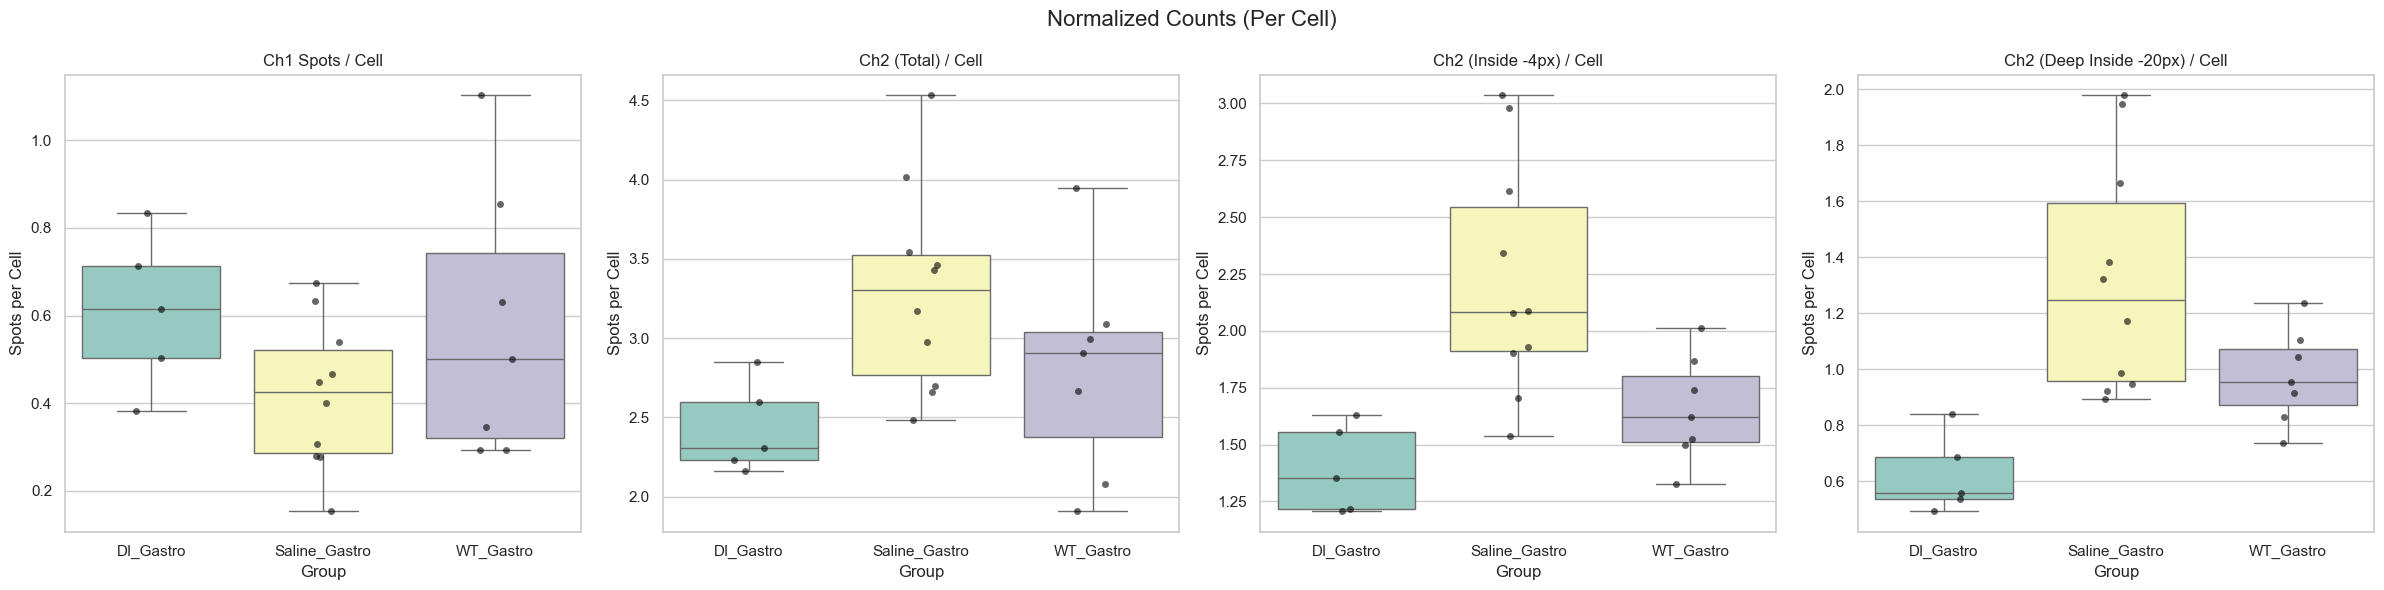


--- Detailed Stats ---
Group                           DI_Gastro  Saline_Gastro  WT_Gastro
Ch1_per_Cell             count   5.000000      10.000000   7.000000
                         mean    0.609554       0.417943   0.574795
                         std     0.175838       0.167552   0.309786
                         min     0.382514       0.153374   0.293839
                         25%     0.502994       0.285450   0.320511
                         50%     0.616162       0.424537   0.500000
                         75%     0.712766       0.522181   0.742952
                         max     0.833333       0.674157   1.102804
Ch2_Total_per_Cell       count   5.000000      10.000000   7.000000
                         mean    2.429809       3.297256   2.797398
                         std     0.285445       0.639904   0.679813
                         min     2.163934       2.482659   1.906667
                         25%     2.233333       2.768498   2.373618
                        

In [3]:
if len(df) > 0:
    # --- Safety Check: Ensure Columns Exist ---
    if 'Ch2_Deep_Inside_per_Cell' not in df.columns:
        print("Calculating Missing Metrics (Deep Inside)...")
        df['Ch2_Deep_Inside_per_Cell'] = df.apply(lambda row: row.get('Ch2_Deep_Inside', 0) / row['Cell_Count'] if row['Cell_Count'] > 0 else 0, axis=1)

    # Set Plot Style
    sns.set_theme(style="whitegrid")
    order = sorted(df['Group'].unique())
    
    # --- Figure 1: Normalized (Per Cell) ---
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    
    # 1. Ch1 Spots per Cell
    sns.boxplot(x='Group', y='Ch1_per_Cell', data=df, ax=axes[0], order=order, palette="Set3")
    sns.stripplot(x='Group', y='Ch1_per_Cell', data=df, ax=axes[0], order=order, color='black', alpha=0.6, jitter=True)
    axes[0].set_title('Ch1 Spots / Cell')
    axes[0].set_ylabel('Spots per Cell')
    
    # 2. Ch2 Total Spots per Cell
    sns.boxplot(x='Group', y='Ch2_Total_per_Cell', data=df, ax=axes[1], order=order, palette="Set3")
    sns.stripplot(x='Group', y='Ch2_Total_per_Cell', data=df, ax=axes[1], order=order, color='black', alpha=0.6, jitter=True)
    axes[1].set_title('Ch2 (Total) / Cell')
    axes[1].set_ylabel('Spots per Cell')

    # 3. Ch2 Inside Spots per Cell (4px)
    sns.boxplot(x='Group', y='Ch2_Inside_per_Cell', data=df, ax=axes[2], order=order, palette="Set3")
    sns.stripplot(x='Group', y='Ch2_Inside_per_Cell', data=df, ax=axes[2], order=order, color='black', alpha=0.6, jitter=True)
    axes[2].set_title(f'Ch2 (Inside -{erosion_pixels}px) / Cell')
    axes[2].set_ylabel('Spots per Cell')
    
    # 4. Ch2 Deep Inside Spots per Cell (20px)
    sns.boxplot(x='Group', y='Ch2_Deep_Inside_per_Cell', data=df, ax=axes[3], order=order, palette="Set3")
    sns.stripplot(x='Group', y='Ch2_Deep_Inside_per_Cell', data=df, ax=axes[3], order=order, color='black', alpha=0.6, jitter=True)
    axes[3].set_title(f'Ch2 (Deep Inside -{deep_erosion_pixels}px) / Cell')
    axes[3].set_ylabel('Spots per Cell')
    
    plt.suptitle("Normalized Counts (Per Cell)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Detailed Stats
    print("\n--- Detailed Stats ---")
    cols = ['Ch1_per_Cell', 'Ch2_Total_per_Cell', 'Ch2_Inside_per_Cell', 'Ch2_Deep_Inside_per_Cell']
    print(df.groupby('Group')[cols].describe().T)